In [70]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import urllib.request
from astropy.io import fits 
from astropy.table import Table
from scipy.special import gamma

from sklearn.decomposition import NMF, FastICA, PCA
from astroML.datasets import sdss_corrected_spectra
from astroML.utils.decorators import pickle_results

In [491]:
#Grafica las decomposiciones
def plotdecom(decompositions):
    n_components=len(decompositions)
    fig = plt.figure(figsize=(5, 6))
    fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                        bottom=0.1, top=0.95, hspace=0.05)

    titles='PCA components'
    i=1

    for j in range(n_components):
        ax = fig.add_subplot(n_components,1,j+1)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(3000, 11999, 1000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(10**logwave, decompositions[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 11000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles)


        if j == 0:
            label = 'mean'
        else:
            label = 'component %i' % j

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)


    plt.show()



#Se crea función para hacer la descomposición
@pickle_results('spec_decompositions.pkl')
def compute_PCA(spectra,n_components=5):
    spec_mean = spectra.mean(0)

    # PCA: use randomized PCA for speed
    pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean,pca.components_])
    return pca_comp



def mipca(spectra):
    '''
    spectra: espectros con los que se hará el pca
    
    Regresa los eigenvalues y eigenvectors
    '''
    spectraxnorm=np.array([spectra[i]-spectra.mean(1)[i] for i in range(spectra.shape[0])])
    spectranorm=np.array([spectraxnorm[i]/spectraxnorm.std(1)[i] for i in range(spectraxnorm.shape[0])])
    Cz=np.matmul(spectranorm.T,spectranorm)/(spectranorm.shape[1]-1)
    evals,evecs=np.linalg.eig(Cz)
    return evals,evecs



# Plot the sequence of reconstructions
def plotrecons(spec,spectra,coeff):
    spec_mean=spectra.mean(0)
    fig = plt.figure(figsize=(6, 14))
    fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

    for i, n in enumerate([0, 5, 20, 50, 100, 500, 1500, 3000, 4627]):
        ax = fig.add_subplot(911 + i)
        ax.plot(wavelengths, spec, '-', c='gray')
        ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

        if i < 3:
            ax.xaxis.set_major_formatter(plt.NullFormatter())

        ax.set_ylim(-10, 25)
        ax.set_ylabel('flux')

        if n == 0:
            text = "mean"
        elif n == 1:
            text = "mean + 1 component\n"
            text += r"$(\sigma^2_{tot} = %.3f)$" % evals_cs[n - 1]
        else:
            text = "mean + %i components\n" % n
            text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

        ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

    fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
    plt.show()

In [ ]:
#Descarga de primer archivo
url_file='https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3587/spPlate-3587-55182.fits'
plates_local='./spPlates/'
plate_file='spPlate-3588-55184.fits'
if not os.path.exists(plates_local):
        os.makedirs(plates_local)

local_file=plates_local+plate_file
if not os.path.exists(local_file):
    print("downloading spplate from %s to %s"
              % (url_file, local_file))
    tmp = urllib.request.urlretrieve(url_file, local_file)
else:
    print('%s  %s present on disk. '%(url_file,local_file))

In [ ]:
#Descarga de segundo archivo
DATA_URL="https://data.sdss.org/sas/dr14/eboss/qso/DR14Q/"
file="DR14Q_v4_4.fits"
local_dir="./"
local_file = os.path.join(local_dir,file)
if not os.path.exists(file):
        print("downloading DR14 quasar dataset from %s to %s"
              % (DATA_URL+file, local_file ))
        tmp = urllib.request.urlretrieve(DATA_URL+local_file, local_file)
        print ("Downloaded file"+local_file)
else:
    print("%s already exist"%(local_file))

Supongamos que tenemos una distribución de puntos uniformemente distribuidos en un hypercubo de dimensión n.El hypercubo está centrado en cero, y tiene una longitud 2R.
¿Cuál es la proporción de puntos que caen dentro de una unidad de distancia a partir del origen?
¿Cómo varia esa proporción conforme aumenta la dimensión n?

Dado que la distribución es uniforme, la cantidad de puntos que están a menos de una unidad de distancia del origen son proporcionales al volumen de una hiperesfera de una unidad de radio, y a su vez, los puntos totale dentro del hipercubo son proporcionales al volumen de este. Entonces la proporcion es:

$P=\frac{V_{esfera}}{V_{cubo}}$

El volumen de una esfera n dimensional de radio R es:

$V_{esfera}=\frac{\pi^{n/2}R^n}{\Gamma(n/2+1)}$

El volumen de un hiper cubo n dimensional de lado 2R es:

$V_{cubo}=(2R)^n$

La proporcion en función de la dimensión es:

$P(n)=\frac{\pi^{n/2}R^n}{(2R)^n \hspace{1.5pt} \Gamma(n/2+1)}=\frac{\pi^{n/2}}{2^n \hspace{1.5pt} \Gamma(n/2+1)}$

Graficamos esta función:

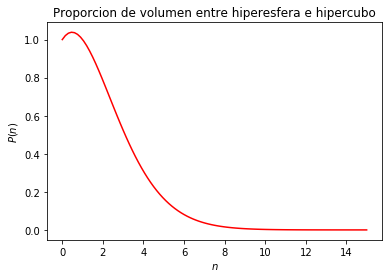

In [2]:
n=np.linspace(0,15,101)
p=np.pi**(n/2)/(2**n*gamma(n/2+1))
plt.plot(n,p,'r');
plt.xlabel(r'$n$')
plt.ylabel(r'$P(n)$')
plt.title('Proporcion de volumen entre hiperesfera e hipercubo');

In [4]:
#Se abre el primer archivo
file=plates_local+plate_file

plate1=fits.open(file)
plugmap=plate1['PLUGMAP'].data
objtype=plugmap['OBJTYPE']

#Se obtiene el flujo
flux=plate1[0].data

#Se obtiene el logaritmo de la longitud de onda
pltheader=plate1[0].header
coeff0=pltheader['COEFF0']
coeff1=pltheader['COEFF1']
logwave=coeff0+coeff1*np.arange(flux.shape[1])

#Se seleccionan los quasares
plugmap=plate1['PLUGMAP'].data
wq=plugmap['OBJTYPE']=='QSO'
fiberid_pm=plugmap['FIBERID']
fiberid_qso=fiberid_pm[wq]

In [412]:
#Se buscan aquellos quasares que filtramos del archivo anterior que estén el el catálogo del segundo archivo
catalog=Table.read('DR14Q_v4_4.fits');

cat=catalog[(catalog['MJD']==55184) & (catalog['PLATE']==3588)]
cat.sort('PLATE')
fiberid_cat=cat['FIBERID']

#fiberid_cat=catalog['FIBERID']

#id de Quasares que se encuentran tanto en el nuevo catalogo como en el archivo de spPlate
fbid_incat=fiberid_qso[np.in1d(fiberid_qso,fiberid_cat)]

In [426]:
catrec=cat[:][np.in1d(fiberid_cat,fbid_incat)]
#catrec=catalog[:][np.in1d(catalog['FIBERID'],fbid_incat)]
zmenos=catrec[catrec['Z']<2.1]
zmas=catrec[catrec['Z']>2.1]
fbid_incat_menos=fiberid_qso[np.in1d(fiberid_qso,zmenos['FIBERID'])]
fbid_incat_mas=fiberid_qso[np.in1d(fiberid_qso,zmas['FIBERID'])]

In [401]:
#Se buscan los redshifts de los quasares en el catálogo filtrado (cat)
#z=catalog[:][np.in1d(catalog['FIBERID'],fbid_incat)]
z=cat['Z'][np.in1d(cat['FIBERID'],fbid_incat)]

In [471]:
#Se buscan los redshifts de los quasares en el catálogo completo
fiberid_catalogo=catalog['FIBERID']
fbid_incat_full=fiberid_qso[np.in1d(fiberid_qso,fiberid_cat)]

In [473]:
#Visualización de los espectros en sistema de referencia en reposo
lrf=[10**logwave/(1+z[i]) for i in range(len(z))]
spectra=np.array([flux[fbid_incat[i]-1] for i in range(len(z))])
spectramas=np.array([flux[fbid_incat_mas[i]-1] for i in range(len(fbid_incat_mas))])
spectramenos=np.array([flux[fbid_incat_menos[i]-1] for i in range(len(fbid_incat_menos))])
spectrafull=np.array([flux[fbid_incat_full[i]-1] for i in range(len(fbid_incat_full))])

# plt.figure(figsize=(15,30),dpi=100)
# i=0
# for i in range(9):
#     plt.subplot(5,2,i+1)
#     plt.plot(lrf[i],spectra[i],label=objtype[fbid_incat[i]-1]+'_'+str(fbid_incat[i])+' z=%.3f'%z[i])
#     plt.ylabel(r'Flux 1E-17 erg/cm^2/s/Ang')
#     plt.xlabel(r'\lambda [\Ang]')
#     plt.ylim(-5,10)
#     plt.legend()

In [477]:
#Se fija la cantidad de componentes
n_components = 5
decompositions = compute_PCA(spectra,n_components)
n_components = 5
decompositionsfull = compute_PCA(spectrafull,n_components)


# n_components = 5
# decompositionsmas = compute_PCA(spectramas,n_components)
# n_components = 2
# decompositionsmenos = compute_PCA(spectramenos,n_components)


@pickle_results: computing results and saving to 'spec_decompositions.pkl'
    - args match:   False
    - kwargs match: True
@pickle_results: computing results and saving to 'spec_decompositions.pkl'
    - args match:   False
    - kwargs match: True
@pickle_results: computing results and saving to 'spec_decompositions.pkl'
    - args match:   False
    - kwargs match: True
@pickle_results: computing results and saving to 'spec_decompositions.pkl'
    - args match:   False
    - kwargs match: True


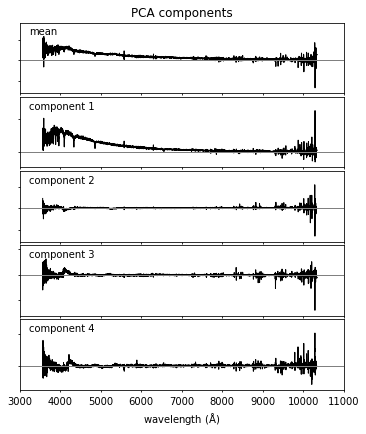

In [486]:
#Visualización de descomposición de cat
plotdecom(decompositions)

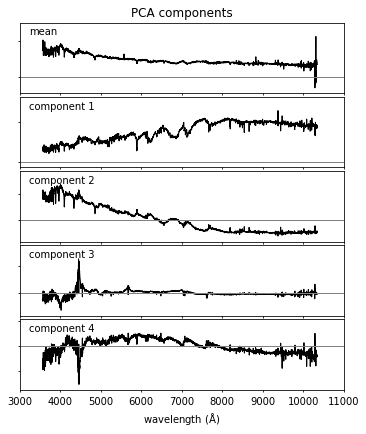

In [487]:
#Visualización de descomposición de catalogo
plotdecom(decompositionsfull)

In [439]:
#Se obtienen eigenvalues y eigenvectors
evals,evecs=mipca(spectra)
evalsmas,evecsmas=mipca(spectramas)
evalsmenos,evecsmenos=mipca(spectramenos)

In [482]:
evalsfull,evecsfull=mipca(spectrafull)

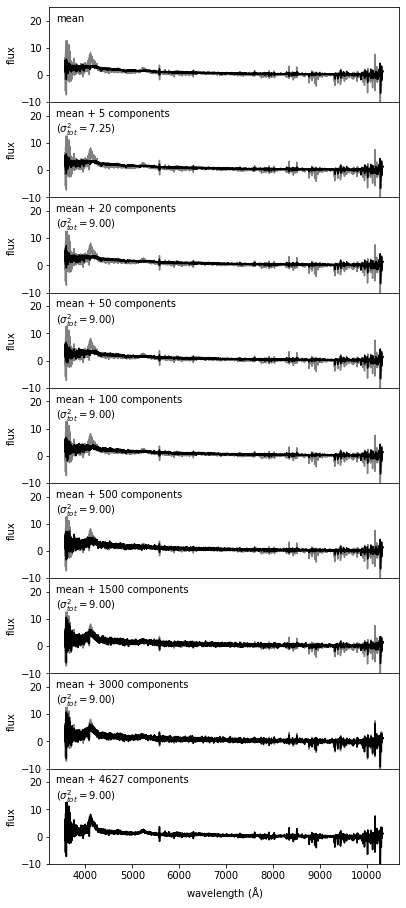

In [492]:
#Se calculan los coeficientes para un espectro en específico
spec = spectra[4]
coeff = np.dot(evecs, spec - spectra.mean(0))
plotrecons(spec,spectra,coeff)

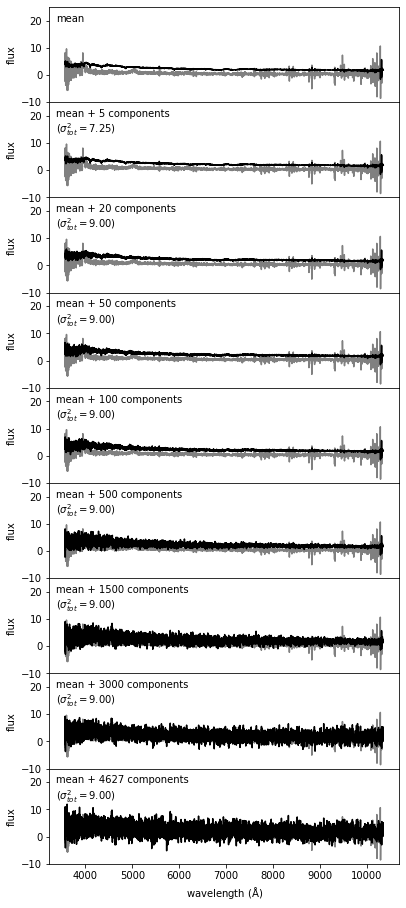

In [501]:
spec = spectrafull[1]
coef=np.dot(evecsfull, spec - spectrafull.mean(0))
plotrecons(spec,spectrafull,coef)